<strong><center>Created by Nooruddin 2022.</center></strong>

In [80]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid

In [81]:
from torchvision import datasets, transforms
transform = transforms.ToTensor()

In [82]:
train_data = datasets.FashionMNIST(root='', train=True, download=True, transform=transform)
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()

In [83]:
type(train_data)

torchvision.datasets.mnist.FashionMNIST

In [84]:
len(train_data)

60000

In [85]:
test_data = datasets.FashionMNIST(root='', train=False, download=True, transform=transform)
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: ToTensor()

In [86]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 9


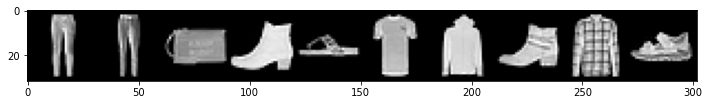

In [87]:
for images,labels in train_loader: 
    break

im = make_grid(images, nrow=10)
plt.figure(figsize=(12,4))

plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [88]:
from torch.utils.data import TensorDataset, DataLoader

In [89]:
"""
Initializing train/test dataloader object which splits the training dataset into small batches of 10 images each
and this can be used later in the CNN model  
"""
torch.manual_seed(101)
bat_sz=10
train_loader = DataLoader(train_data,batch_size=bat_sz,shuffle=True) #use pin_memory=True in the parameters after shuffle to change to cuda
test_loader = DataLoader(test_data,batch_size=bat_sz,shuffle=False) #use pin_memory=True in the parameters after shuffle to change to cuda

In [90]:
class_names = ['T-shirt','Trouser','Sweater','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot']

In [91]:
class CONVNN(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.conv1  = nn.Conv2d(1, 10 , 3 , 1, padding=1)# We will ne using 3X3 filter/kernel and stride of 1 with padding of size 1 as MNIST images re centered and don't have any info at the border/edges
        self.conv2  = nn.Conv2d(10, 16, 3 , 1,padding=1)
        self.layer1 = nn.Linear(16*7*7,120) # we need to calculate the resulting number of matrices passing thru the conv layer and put that corressponding o/p as the linear layer input
        self.layer2 = nn.Linear(120,84)
        self.layer3 = nn.Linear(84,10)
        
    def forward(self,x):
        
        x= F.max_pool2d(  F.relu(self.conv1(x)) , 2, 2) #adding relu and max pooling the same line
        x= F.max_pool2d(  F.relu(self.conv2(x)) , 2, 2) #adding relu and max pooling the same line
        x= F.relu(self.layer1(x.view(-1,16*7*7))) #flattening by using View and no dropout has been added
        x= F.relu(self.layer2(x))
        x= F.log_softmax(self.layer3(x),dim=1) #multiclass classificaiton
        
        return x
    

In [92]:
torch.manual_seed(101)
model = CONVNN()#to instansiate the model as cuda use "model = CONVNN().to(device) " or "model.cuda()" so that whatever the tensors we are passing to the model will be saved in GPU and operations will be performed on that
model

CONVNN(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Linear(in_features=784, out_features=120, bias=True)
  (layer2): Linear(in_features=120, out_features=84, bias=True)
  (layer3): Linear(in_features=84, out_features=10, bias=True)
)

In [93]:
torch.manual_seed(101)
model = CONVNN()#to instansiate the model as cuda use "model = CONVNN().to(device) " or "model.cuda()" so that whatever the tensors we are passing to the model will be saved in GPU and operations will be performed on that
model

CONVNN(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Linear(in_features=784, out_features=120, bias=True)
  (layer2): Linear(in_features=120, out_features=84, bias=True)
  (layer3): Linear(in_features=84, out_features=10, bias=True)
)

In [94]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [96]:
epochs = 9
train_loss= []
test_loss= []
train_acc=[]
test_acc = []

print(f'\nConvolutional Neural Network Model Metrics:\n')
print(f'\t This CNN model configuration has {epochs} epochs with each batch size of {bat_sz} images:\n')
for i in range(epochs):
    
    train_crt_pred = 0
    test_crt_pred = 0
    conf_mat= torch.FloatTensor([])
    
    for b,(x_train,y_train) in enumerate (train_loader):
        b += 1
        y_pred = model.forward(x_train)
        loss= criterion(y_pred,y_train)
        
        buffer = torch.max(y_pred.data, 1) [1]
        batch_acc = (buffer == y_train).sum()
        train_crt_pred +=  batch_acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        if b% int((len(train_data)/bat_sz)/5 )  == 0:
            print(f'Epoch{i+1:2} Batch {b:4} loss: {loss.item():5.2f} Train Accuracy: {train_crt_pred.item()*100/(bat_sz*b):6.3f}%')
    
    train_loss.append(loss)  #loss after 1 epoch
    train_acc.append(train_crt_pred) # crt predictions after 1 epoch
    
    
    with torch.no_grad():  #testing after 1 complete epoch
        for b,(x_test,y_test) in enumerate (test_loader):
            b += 1
            y_eval = model.forward(x_test)
            loss= criterion(y_eval,y_test)
            buffer1 = torch.max(y_eval.data, 1) [1]
            conf_mat =  torch.cat((conf_mat.float(),buffer1.float()),0)
            batch_acc = (buffer1 == y_test).sum()
            test_crt_pred +=  batch_acc
    
    test_loss.append(loss) #test loss after the last completed epoch
    test_acc.append(test_crt_pred) # crt predictions using the last completed epoch

    print(f'After {i+1} Epoch(s) the Train Accuracy is {(train_crt_pred.item()/len(train_data))*100:6.3f}% and Test Accuracy is {(test_crt_pred.item()/len(test_data))*100:6.3f}% \n')     
    
        


Convolutional Neural Network Model Metrics:

	 This CNN model configuration has 9 epochs with each batch size of 10 images:

Epoch 1 Batch 1200 loss:  0.17 Train Accuracy: 72.558%
Epoch 1 Batch 2400 loss:  0.40 Train Accuracy: 77.971%
Epoch 1 Batch 3600 loss:  0.18 Train Accuracy: 80.439%
Epoch 1 Batch 4800 loss:  0.58 Train Accuracy: 82.067%
Epoch 1 Batch 6000 loss:  0.61 Train Accuracy: 83.182%
After 1 Epoch(s) the Train Accuracy is 83.182% and Test Accuracy is 87.020% 

Epoch 2 Batch 1200 loss:  0.21 Train Accuracy: 88.375%
Epoch 2 Batch 2400 loss:  0.83 Train Accuracy: 88.692%
Epoch 2 Batch 3600 loss:  0.12 Train Accuracy: 88.797%
Epoch 2 Batch 4800 loss:  0.17 Train Accuracy: 88.831%
Epoch 2 Batch 6000 loss:  0.03 Train Accuracy: 88.935%
After 2 Epoch(s) the Train Accuracy is 88.935% and Test Accuracy is 88.620% 

Epoch 3 Batch 1200 loss:  0.28 Train Accuracy: 90.350%
Epoch 3 Batch 2400 loss:  0.32 Train Accuracy: 90.200%
Epoch 3 Batch 3600 loss:  0.96 Train Accuracy: 90.411%
Epo

In [99]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns


The Confusion Matrix is plotted below:


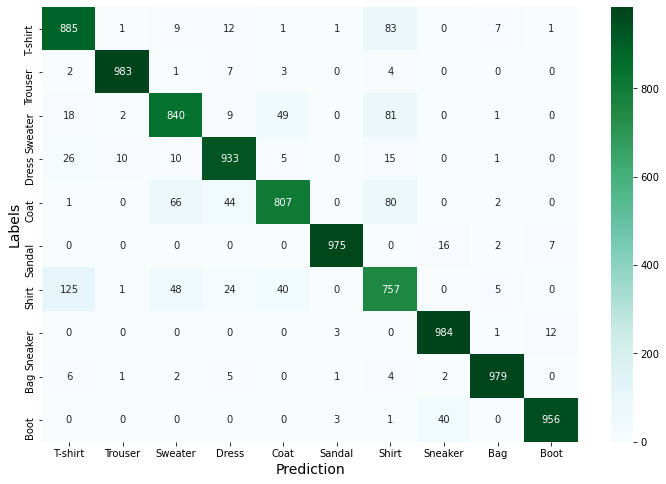


The Classification Report is plotted below: 

               precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      1000
         1.0       0.98      0.98      0.98      1000
         2.0       0.86      0.84      0.85      1000
         3.0       0.90      0.93      0.92      1000
         4.0       0.89      0.81      0.85      1000
         5.0       0.99      0.97      0.98      1000
         6.0       0.74      0.76      0.75      1000
         7.0       0.94      0.98      0.96      1000
         8.0       0.98      0.98      0.98      1000
         9.0       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [100]:
print('\nThe Confusion Matrix is plotted below:')
cfmt =pd.DataFrame(confusion_matrix(torch.Tensor([r for q,r in test_data]).reshape(-1,1),conf_mat.reshape(-1,1),labels=[0,1,2,3,4,5,6,7,8,9]),index=class_names,columns=class_names)
plt.figure(figsize=(12,8))
sns.heatmap(cfmt,annot=True,cmap='BuGn',fmt="d")
plt.xlabel("Prediction",fontsize=14)
plt.ylabel("Labels",fontsize=14)
plt.show()
print('\nThe Classification Report is plotted below: \n\n',classification_report(torch.Tensor([r for q,r in test_data]).reshape(-1,1),conf_mat.reshape(-1,1)))


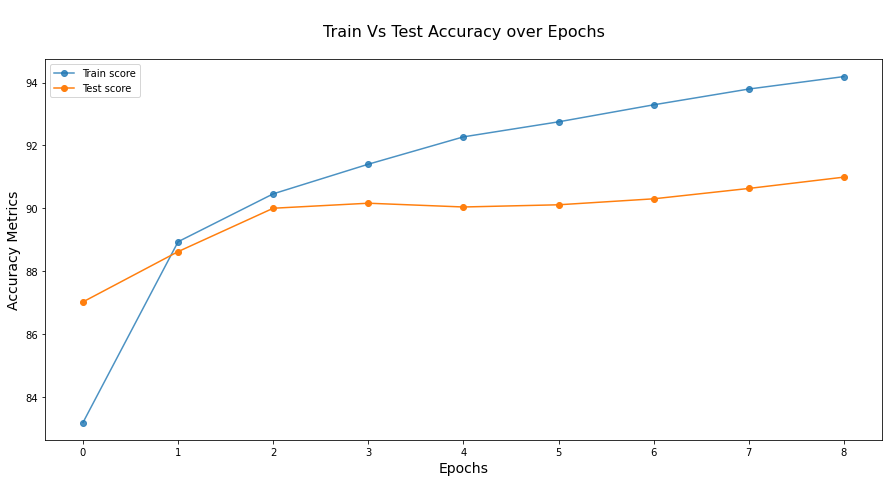

In [101]:
plt.figure(figsize=(15,7))
plt.plot([(t/(len(train_data)/100)) for t in train_acc], label='Train score',marker='o',alpha=0.8)
plt.plot([(t/(len(test_data)/100)) for t in test_acc], label='Test score',marker='o')
plt.title('\nTrain Vs Test Accuracy over Epochs\n',fontsize=16)
# plt.xticks(np.arange(0,20,1));
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Accuracy Metrics',fontsize=14)
plt.legend();


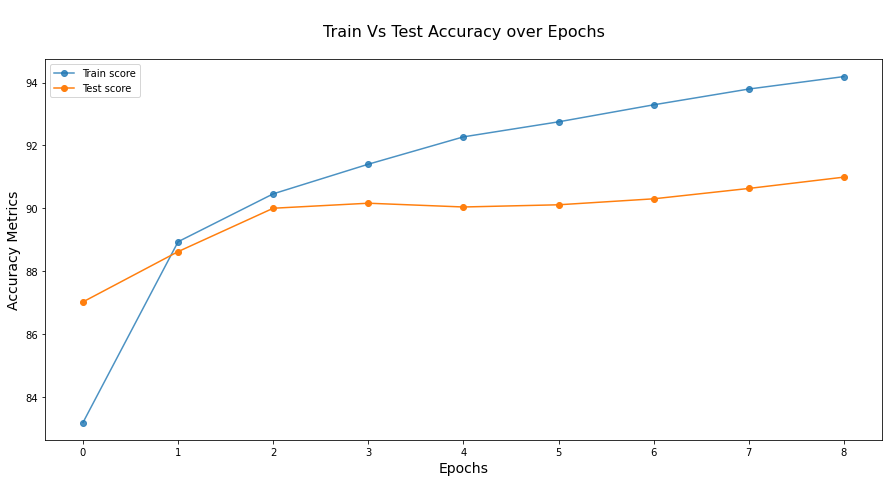

In [105]:
plt.figure(figsize=(15,7))
plt.plot([(t/(len(train_data)/100)) for t in train_acc], label='Train score',marker='o',alpha=0.8)
plt.plot([(t/(len(test_data)/100)) for t in test_acc], label='Test score',marker='o')
plt.title('\nTrain Vs Test Accuracy over Epochs\n',fontsize=16)
# plt.xticks(np.arange(0,20,1));
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Accuracy Metrics',fontsize=14)
plt.legend();

In [1]:
torch.save(model.state_dict(), 'FASHION_MNIST_CNN_Nooruddin.pt')

NameError: name 'torch' is not defined